## Time series analysis of azimuth / range offset


In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt

from mintpy.objects import timeseries
from mintpy.utils import readfile, writefile, plot as pp
from mintpy import view

work_dir = '/Users/yunjunz/data/ChileSenAT149/mintpyOffset'
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/ChileSenAT149/mintpyOffset


### 1. Estimate offset time-series:

Here is my MintPy configuration file `SanAndreasSenDT42F472.txt`:

```cfg
# vim: set filetype=cfg:
mintpy.load.processor      = isce  #[isce,snap,gamma,roipac], auto for isce
##---------for ISCE only:
mintpy.load.metaFile       = ../master/IW1.xml  #[path2metadata_file], i.e.: ./master/IW1.xml, ./masterShelve/data.dat
mintpy.load.baselineDir    = ../baselines  #[path2baseline_dir], i.e.: ./baselines
##---------offset datasets:
mintpy.load.azOffFile      = ../merged/offsets/*/filtAz*.off  #[path2az_off_file], optional
mintpy.load.rgOffFile      = ../merged/offsets/*/filtRa*.off  #[path2rg_off_file], optional
mintpy.load.offSnrFile     = ../merged/offsets/*/*_snr*.bip   #[path2off_SNR_file], optional
##---------geometry datasets:
mintpy.load.demFile        = ../merged/offsets/geom_master/hgt.rdr  #[path2hgt_file]
mintpy.load.lookupYFile    = ../merged/offsets/geom_master/lat.rdr  #[path2lat_file], not required for geocoded data
mintpy.load.lookupXFile    = ../merged/offsets/geom_master/lon.rdr  #[path2lon_file], not required for geocoded data
mintpy.load.incAngleFile   = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.azAngleFile    = ../merged/offsets/geom_master/los.rdr  #[path2los_file], optional
mintpy.load.shadowMaskFile = ../merged/offsets/geom_master/shadowMask.rdr  #[path2shadow_file], optional
mintpy.load.waterMaskFile  = ../merged/offsets/geom_master/waterMask.rdr  #[path2water_mask_file], optional

mintpy.network.connNumMax                       = 2
```

Run the following in the terminal:

```bash
smallbaselineApp.py SanAndreasSenDT42F472.txt --end modify_network
ifgram_inversion.py  inputs/ifgramStack.h5 -i azimuthOffset --water-mask waterMask.h5
ifgram_inversion.py  inputs/ifgramStack.h5 -i rangeOffset --water-mask waterMask.h5
reference_date.py timeseriesAz.h5 --ref-date 20200111
reference_date.py timeseriesRg.h5 --ref-date 20200111
timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5
timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5
```

### 2. Prepare mask

number of valid pixels: 28182
number of valid pixels after temp_coh_az: 25098
number of valid pixels after temp_coh_rg: 24788
number of valid pixels after water_mask: 24788
number of valid pixels after velocity_az: 22823
number of valid pixels after velocity_rg: 22823
delete exsited file: maskTempCoh.h5
create HDF5 file: maskTempCoh.h5 with w mode
create dataset /mask of bool       in size of (122, 231)           with compression=None
finished writing to maskTempCoh.h5
ASCENDING orbit -> flip up-down


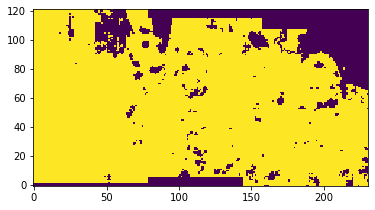

In [2]:
## temporal coherence
min_tcoh = 0.999
tcoh_az = readfile.read('temporalCoherenceAz.h5')[0]
tcoh_rg = readfile.read('temporalCoherenceRg.h5')[0]
mask = np.ones(tcoh_az.shape, dtype=np.bool_)
print('number of valid pixels: {}'.format(np.sum(mask)))
mask *= tcoh_az > min_tcoh
print('number of valid pixels after temp_coh_az: {}'.format(np.sum(mask)))
mask *= tcoh_rg > min_tcoh
print('number of valid pixels after temp_coh_rg: {}'.format(np.sum(mask)))

## water
water_mask = readfile.read('waterMask.h5')[0]
mask *= water_mask
print('number of valid pixels after water_mask: {}'.format(np.sum(mask)))

## velocity
max_vel = 0.2 # m/year
vel_az = readfile.read('velocityAz.h5', datasetName='velocity')[0]
vel_rg = readfile.read('velocityRg.h5', datasetName='velocity')[0]
mask *= np.abs(vel_az) < max_vel
print('number of valid pixels after velocity_az: {}'.format(np.sum(mask)))
mask *= np.abs(vel_rg) < max_vel
print('number of valid pixels after velocity_rg: {}'.format(np.sum(mask)))

## write to file
mask_file = 'maskTempCoh.h5'
atr = readfile.read_attribute('temporalCoherenceAz.h5')
atr['FILE_TYPE'] = 'mask'
atr['DATA_TYPE'] = 'bool'
atr['UNIT'] = '1'
writefile.write(mask, out_file=mask_file, metadata=atr)

## plot
fig, ax = plt.subplots()
ax.imshow(mask)
pp.auto_flip_direction(atr, ax)
plt.show()

### 3. Plot offset time-series

In [15]:
# plot
!plot_network.py inputs/ifgramStack.h5 -d offsetSNR -v 0 50 --nodisplay
!view.py timeseriesAz.h5 -v -50 50 --nodisplay --noverbose
!view.py timeseriesRg.h5 -v -50 50 --nodisplay --noverbose
!view.py temporalCoherenceAz.h5 --nodisplay --noverbose
!view.py temporalCoherenceRg.h5 --nodisplay --noverbose
!view.py velocityAz.h5 velocity --nodisplay --noverbose
!view.py velocityRg.h5 velocity --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 azimuthOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 rangeOffset --mask maskTempCoh.h5 -v -0.1 0.1 --nodisplay --noverbose
!view.py inputs/ifgramStack.h5 offsetSNR -v 0 200 -c RdBu_truncate --cmap-vlist 0 0.1 1 --nodisplay --noverbose

# move .pdf/png files to pic folder
!mv *pdf *png ./pic/

# time-series

read temporal/spatial baseline info from file: inputs/ifgramStack.h5
['ifgramStack_offsetSNR_spatialAvg.txt'] exists and is newer than ['inputs/ifgramStack.h5', 'waterMask.h5'] --> skip.
ifgramStack_offsetSNR_spatialAvg.txt already exists, read it directly
number of acquisitions: 104
number of interferograms: 306
--------------------------------------------------
number of interferograms marked as drop: 101
number of interferograms marked as keep: 205
number of acquisitions marked as drop: 0
max coherence of excluded interferograms: 39.0475
save figure to BperpHistory.pdf
save figure to CoherenceMatrix.pdf
save figure to CoherenceHistory.pdf
max perpendicular baseline: 196.89 m
max temporal      baseline: 120.0 days
showing coherence
data range: [11.6364, 43.706]
display range: [0.0, 50.0]
save figure to Network.pdf


#### Range offset time-series

<p align="left">
  <img src="docs/SenAT149/timeseriesRg.png">
</p>

#### Azimuth offset time-series

<p align="left">
  <img src="docs/SenAT149/timeseriesAz.png">
</p>

### 4. Get median and mean offset for each acquisition

open timeseries file: timeseriesRg.h5
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_rgOff.png


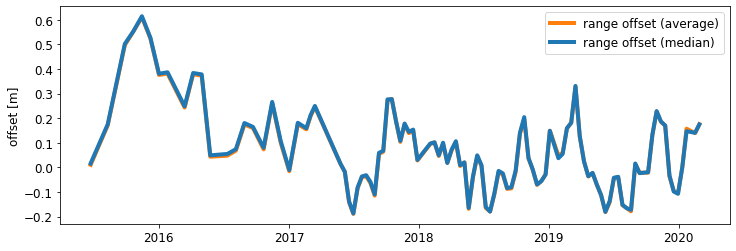

In [7]:
ts_file = 'timeseriesRg.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data, atr = readfile.read(ts_file)
ts_data = ts_data.reshape(ts_obj.numDate, -1) # flatten
ts_data[:, mask.flatten()==0] = np.nan #mask

## calculate median and mean
ts_med = np.nanmedian(ts_data, axis=-1)
ts_avg = np.nanmean(ts_data, axis=-1)

## plot
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(ts_obj.times, ts_avg, linewidth=4, color=pp.mplColors[1], label='range offset (average)')
ax.plot(ts_obj.times, ts_med, linewidth=4, color=pp.mplColors[0], label='range offset (median)')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_rgOff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

open timeseries file: timeseriesAz.h5
save figure to file /Users/yunjunz/data/ChileSenAT149/mintpyOffset/TS_azOff.png


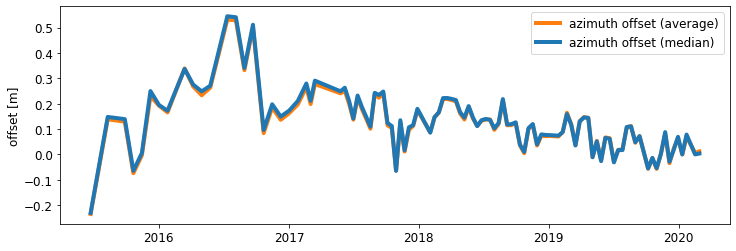

In [8]:
ts_file = 'timeseriesAz.h5'
ts_obj = timeseries(ts_file)
ts_obj.open()

## read data
ts_data, atr = readfile.read(ts_file)
ts_data = ts_data.reshape(ts_obj.numDate, -1) # flatten
ts_data[:, mask.flatten()==0] = np.nan #mask

## calculate median and mean
ts_med = np.nanmedian(ts_data, axis=-1)
ts_avg = np.nanmean(ts_data, axis=-1)

## plot
fig, ax = plt.subplots(figsize=[12, 4])
ax.plot(ts_obj.times, ts_avg, linewidth=4, color=pp.mplColors[1], label='azimuth offset (average)')
ax.plot(ts_obj.times, ts_med, linewidth=4, color=pp.mplColors[0], label='azimuth offset (median)')
ax.set_ylabel('offset [m]')
#ax.set_xlim(left=ts_obj.times[-30])
plt.legend()

# output
out_fig = os.path.abspath('TS_azOff.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()